In [51]:
# importing libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score


In [84]:
df = pd.read_csv("loan_approval_dataset.csv")
df.head()

,loan_id,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
0,1,2,Graduate,No,9600000,29900000,12,778,2400000,17600000,22700000,8000000,Approved
1,2,0,Not Graduate,Yes,4100000,12200000,8,417,2700000,2200000,8800000,3300000,Rejected
2,3,3,Graduate,No,9100000,29700000,20,506,7100000,4500000,33300000,12800000,Rejected
3,4,3,Graduate,No,8200000,30700000,8,467,18200000,3300000,23300000,7900000,Rejected
4,5,5,Not Graduate,Yes,9800000,24200000,20,382,12400000,8200000,29400000,5000000,Rejected


In [59]:
df.shape

(4269, 13)

Checking if data has missing values.

In [60]:
df.isna().sum()

loan_id                      0
 no_of_dependents            0
 education                   0
 self_employed               0
 income_annum                0
 loan_amount                 0
 loan_term                   0
 cibil_score                 0
 residential_assets_value    0
 commercial_assets_value     0
 luxury_assets_value         0
 bank_asset_value            0
 loan_status                 0
dtype: int64

Checking datatypes

In [61]:
df.dtypes

loan_id                       int64
 no_of_dependents             int64
 education                   object
 self_employed               object
 income_annum                 int64
 loan_amount                  int64
 loan_term                    int64
 cibil_score                  int64
 residential_assets_value     int64
 commercial_assets_value      int64
 luxury_assets_value          int64
 bank_asset_value             int64
 loan_status                 object
dtype: object

Removing loan_id as it's an identifying variable.

In [86]:
df.drop(["loan_id"], axis = 1, inplace = True)

Encoding categorical variables to numerical (binary).

In [87]:
df[' loan_status'] = df[' loan_status'].map({' Approved': 1, ' Rejected':0})
df[' education'] = df[' education'].map({' Graduate': 1, ' Not Graduate':0})
df[' self_employed'] = df[' self_employed'].map({' Yes': 1, ' No' :0})

In [ ]:
df.describe()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
count,4269.000000,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4269.000000,4269.000000,4.269000e+03,4.269000e+03,4.269000e+03,4.269000e+03,4269.000000
mean,2.498712,0.502225,0.503631,5.059124e+06,1.513345e+07,10.900445,599.936051,7.472617e+06,4.973155e+06,1.512631e+07,4.976692e+06,0.622160
std,1.695910,0.500054,0.500045,2.806840e+06,9.043363e+06,5.709187,172.430401,6.503637e+06,4.388966e+06,9.103754e+06,3.250185e+06,0.484904
min,0.000000,0.000000,0.000000,2.000000e+05,3.000000e+05,2.000000,300.000000,-1.000000e+05,0.000000e+00,3.000000e+05,0.000000e+00,0.000000
25%,1.000000,0.000000,0.000000,2.700000e+06,7.700000e+06,6.000000,453.000000,2.200000e+06,1.300000e+06,7.500000e+06,2.300000e+06,0.000000
50%,3.000000,1.000000,1.000000,5.100000e+06,1.450000e+07,10.000000,600.000000,5.600000e+06,3.700000e+06,1.460000e+07,4.600000e+06,1.000000
75%,4.000000,1.000000,1.000000,7.500000e+06,2.150000e+07,16.000000,748.000000,1.130000e+07,7.600000e+06,2.170000e+07,7.100000e+06,1.000000
max,5.000000,1.000000,1.000000,9.900000e+06,3.950000e+07,20.000000,900.000000,2.910000e+07,1.940000e+07,3.920000e+07,1.470000e+07,1.000000


In [93]:
df[' residential_assets_value'].min()

-100000

In [95]:
df.corr()

,no_of_dependents,education,self_employed,income_annum,loan_amount,loan_term,cibil_score,residential_assets_value,commercial_assets_value,luxury_assets_value,bank_asset_value,loan_status
no_of_dependents,1.000000,0.002697,0.000765,0.007266,-0.003366,-0.020111,-0.009998,0.007376,-0.001531,0.002817,0.011163,-0.018114
education,0.002697,1.000000,-0.023224,0.011625,0.010631,-0.008417,-0.004649,0.010930,-0.006763,0.012471,0.009424,0.004918
self_employed,0.000765,-0.023224,1.000000,0.002368,0.001450,0.004107,-0.004866,0.006144,-0.017998,0.004413,-0.000215,0.000345
income_annum,0.007266,0.011625,0.002368,1.000000,0.927470,0.011488,-0.023034,0.636841,0.640328,0.929145,0.851093,-0.015189
loan_amount,-0.003366,0.010631,0.001450,0.927470,1.000000,0.008437,-0.017035,0.594596,0.603188,0.860914,0.788122,0.016150
loan_term,-0.020111,-0.008417,0.004107,0.011488,0.008437,1.000000,0.007810,0.008016,-0.005478,0.012490,0.017177,-0.113036
cibil_score,-0.009998,-0.004649,-0.004866,-0.023034,-0.017035,0.007810,1.000000,-0.019947,-0.003769,-0.028618,-0.015478,0.770518
residential_assets_value,0.007376,0.010930,0.006144,0.636841,0.594596,0.008016,-0.019947,1.000000,0.414786,0.590932,0.527418,-0.014367
commercial_assets_value,-0.001531,-0.006763,-0.017998,0.640328,0.603188,-0.005478,-0.003769,0.414786,1.000000,0.591128,0.548576,0.008246
luxury_assets_value,0.002817,0.012471,0.004413,0.929145,0.860914,0.012490,-0.028618,0.590932,0.591128,1.000000,0.788517,-0.015465


<Axes: >

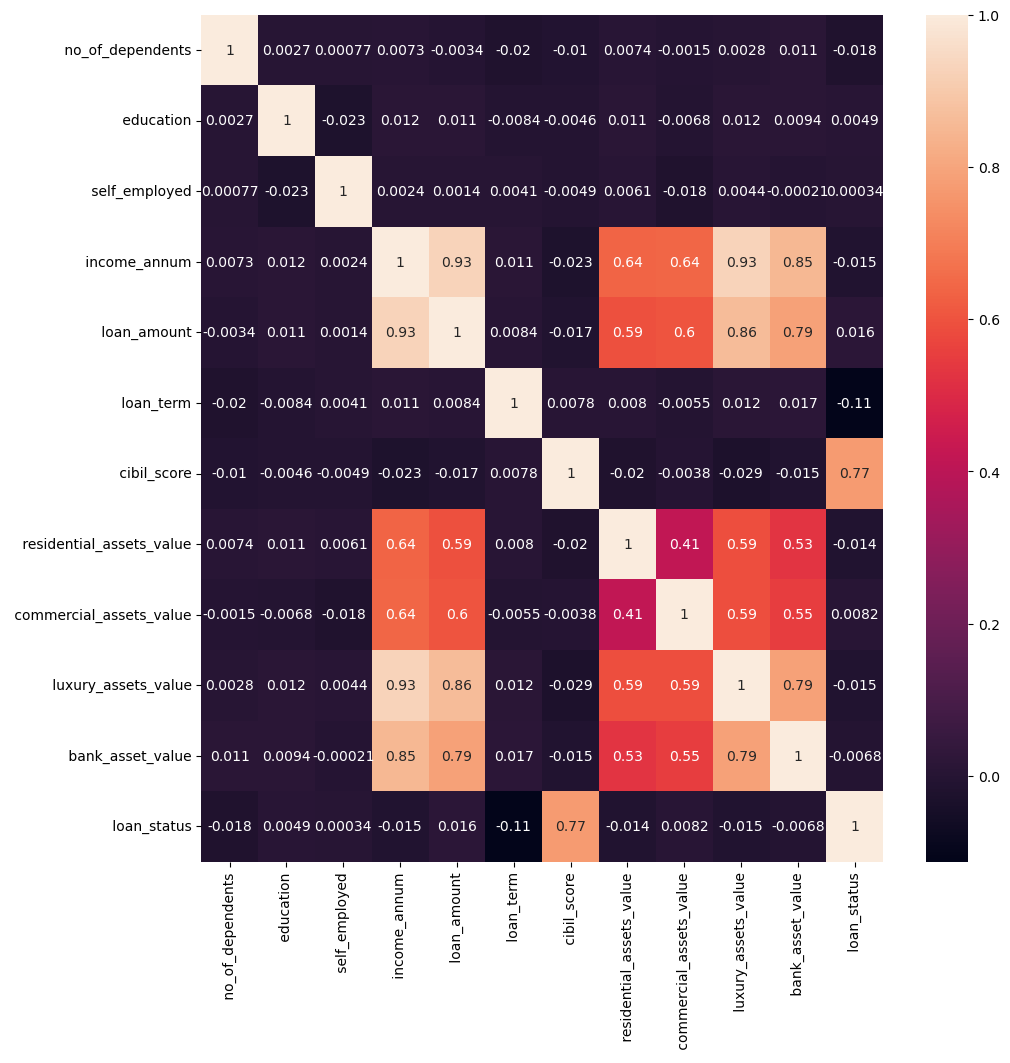

In [98]:
plt.figure(figsize=(11,11))
sns.heatmap(df.corr(), annot=True)

In [ ]:
#df['Movable_assets'] = df[' luxury_assets_value'] + df[' bank_asset_value']
#df['Immovable_assets'] = df[' residential_assets_value'] + df[' commercial_assets_value']

Data visuals

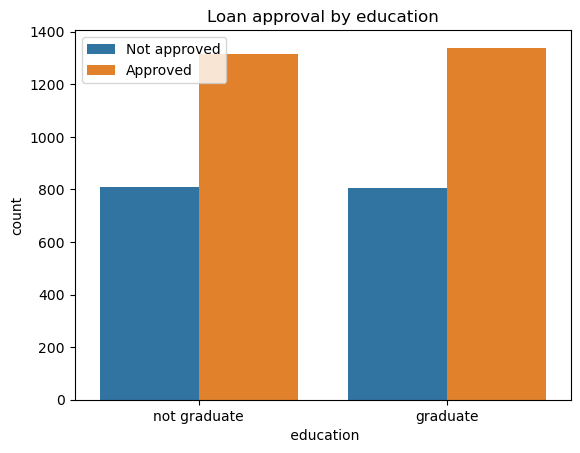

In [ ]:
sns.countplot(data = df, x = ' education', hue = ' loan_status')
plt.legend(["Not approved", "Approved"], loc = 'upper left')
plt.title("Loan approval by education")
plt.xticks([0,1], ["Not graduate", "Graduate"])
plt.show()

In [ ]:

X = df.drop([' loan_status'], axis = 1)
y = df[' loan_status']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

model = RandomForestClassifier()
model.fit(X_train, y_train)
predictions = model.predict(X_test)
print(f'Accuracy: {accuracy_score(y_test, predictions) * 100:.2f}%')

Accuracy: 57.26%


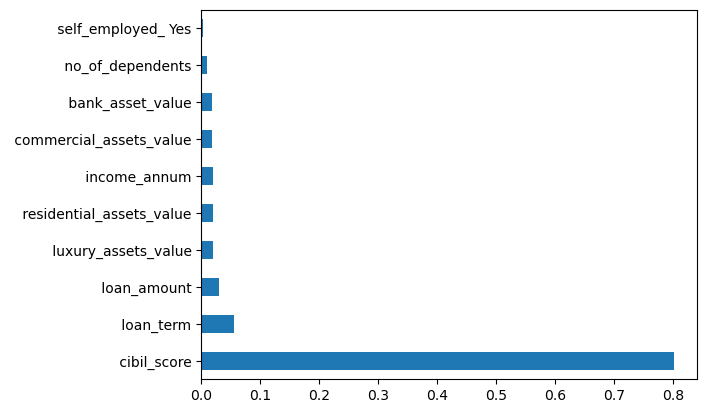

In [45]:
import matplotlib.pyplot as plt

feat_importances = pd.Series(model.feature_importances_, index = X.columns)
feat_importances.nlargest(10).plot(kind = 'barh')
plt.show()